<a href="https://colab.research.google.com/github/guidoivetta/clustering-TM-2021/blob/main/Clustering_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

!python -m spacy download es_core_news_md

     |████████████████████████████████| 78.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [ ]:
nlp = spacy.load('es_core_news_md')

In [ ]:
drive_path = '/content/drive/MyDrive/Text-Mining/'
filename = "lavoztextodump.txt"
text_file = open(drive_path+filename, "r")
dataset = text_file.read()
text_file.close()

In [ ]:
doc = nlp(dataset[:1000000])

In [ ]:
longer_sents = [sent for sent in doc.sents if len(sent) > 10]

lemmas = []
for sent in longer_sents:
    for word in sent:
        if word.is_alpha:
            lemmas.append(word.lemma_)
            
lemma_counter = Counter(lemmas)
len(longer_sents)

5995

In [ ]:
features_dict = {}
threshold_w = 10
threshold_c = 50

for sent in longer_sents:
  for word in sent:
    l = word.lemma_
    if lemma_counter[l] < threshold_w or not word.is_alpha:
        continue
    
    if not l in features_dict:
        l_features = {}
    else:
        l_features = features_dict[l]

    pos = "POS__" + word.pos_
    if not pos in l_features:
        l_features[pos] = 0
    l_features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in l_features:
        l_features[dep] = 0
    l_features[dep] += 1

    tag = "TAG__" + word.tag_
    if not tag in l_features:
        l_features[tag] = 0
    l_features[tag] += 1

    dep_triple = "TRIPLE__" + l + "__" + word.dep_ + "__" + word.head.lemma_
    if not dep_triple in l_features:
        l_features[dep_triple] = 0
    l_features[dep_triple] += 1

    ent_type = word.ent_type_
    if ent_type is not '':
      if not ent_type in l_features:
        l_features[ent_type] = 0
      l_features[ent_type] += 1
    
    for other_word in sent:
      if other_word == word:
        continue
      if lemma_counter[other_word.lemma_] > threshold_c:
        if other_word.like_num:
          context = "NUM__"
        else:
          context = other_word.lemma_
        if not context in l_features:
            l_features[context] = 0
        l_features[context] += 1

    features_dict[l] = l_features    

features_matrix = []
key_words = {}
wid = 0
for d in features_dict:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features_matrix.append(features_dict[d])

In [ ]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features_matrix)

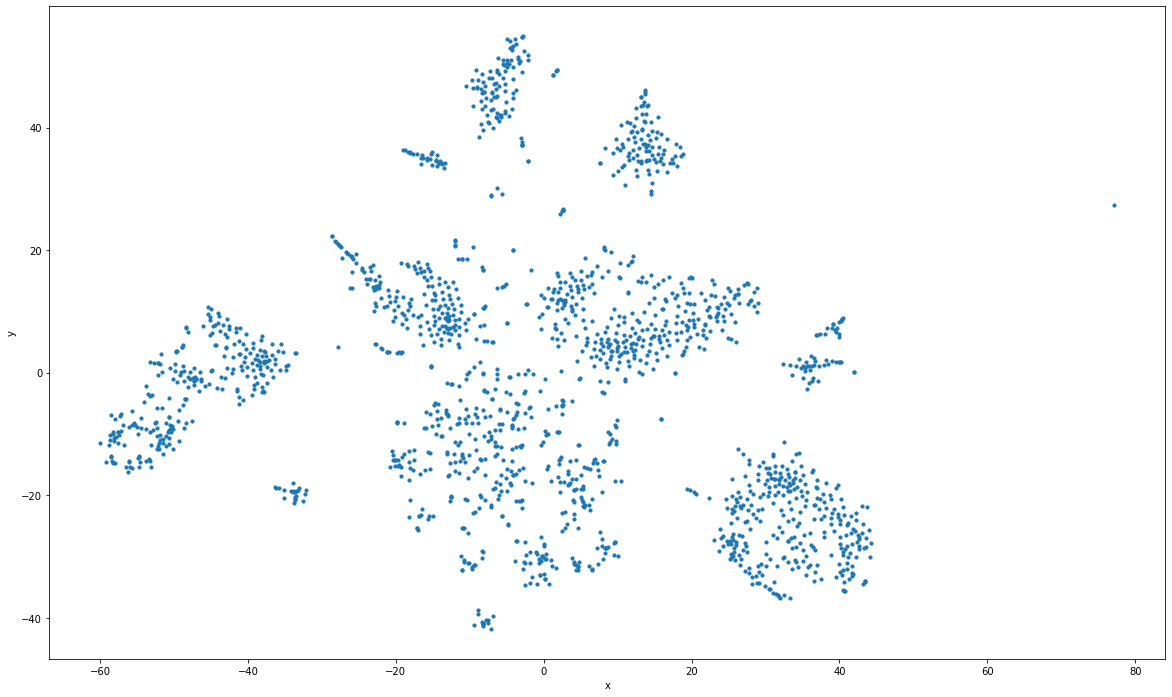

In [ ]:
matrix_normed = matrix / matrix.max(axis=0)

variances = np.square(matrix_normed).mean(axis=0)-np.square(matrix_normed.mean(axis=0))

threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))



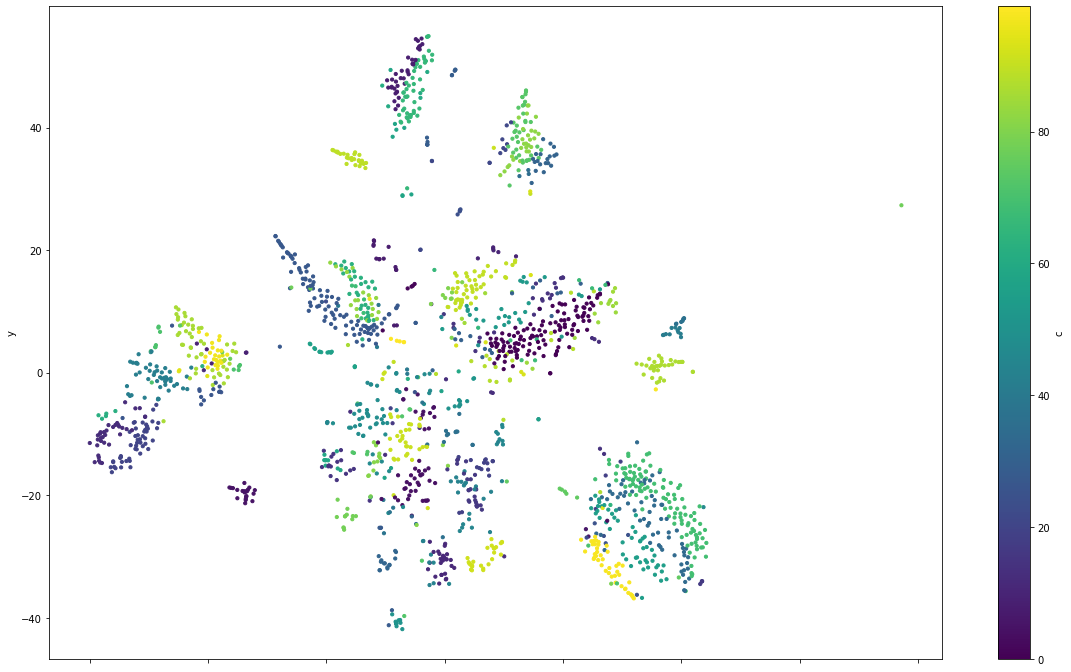

In [ ]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

clusters = clustering(100)

pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)


pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

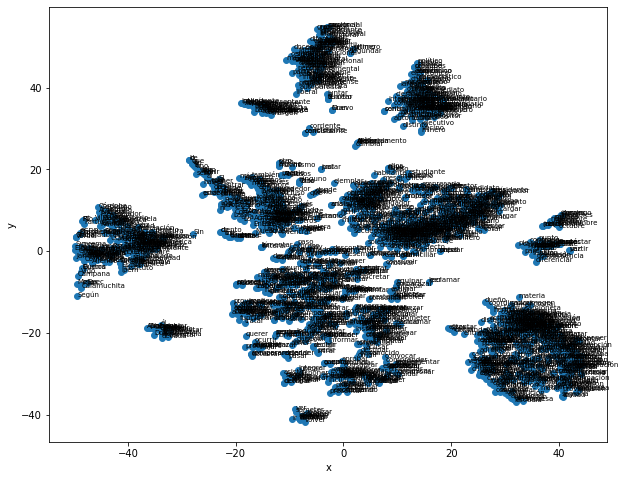

In [ ]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=7)
        
plot_region(x_bounds=(-50, 60), y_bounds=(-90, 70))

In [ ]:
# Días de la semana y meses
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["Poder"]]]
print(printer)

['Ley', 'Dirección', 'Secretaría', 'Comisión', 'Unión', 'Voz', 'Poder', 'Asociación', 'Día', 'Club', 'Iglesia', 'Circunvalación', 'Fiat', 'Banco', 'Senado', 'Fuerza', 'Iberia', 'Economía', 'VIH', 'Aerolíneas', 'Grupo', 'Fundación', 'Embraer', 'ETA']


In [ ]:
from gensim.models import Word2Vec

sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(dataset[:1000000])]
model = Word2Vec(sentences, min_count=10)

In [ ]:
model.wv.most_similar('lunes', topn=10)

[('juicio', 0.9996095299720764),
 ('Fernández', 0.9995346665382385),
 ('hechos', 0.9993749856948853),
 ('sigue', 0.9993215799331665),
 ('Llosa', 0.9992803931236267),
 ('régimen', 0.9992023706436157),
 ('tampoco', 0.9991653561592102),
 ('lleva', 0.9991477727890015),
 ('comunicación', 0.9991322755813599),
 ('Vargas', 0.999126672744751)]

In [ ]:
[word for word in key_words if clusters[key_words[word]] == clusters[key_words["lunes"]]]

['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'domingo']